# Tutorial 6: Galactic Binaries & RJMCMC

In the sixth tutorial, we will examine Galactic Binary waveforms. We will then use them in fixed-dimensional MCMC and then in RJMCMC. We use RJMCMC to perform model selection on the number of sources in the data. 

In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *
from lisatools.sensitivity import get_sensitivity

## Task 1: Build and plot a Galacic Binary waveform using `GBGPU`

In [20]:
# imports
from gbgpu.gbgpu import GBGPU
from gbgpu.thirdbody import GBGPUThirdBody

In [41]:
gb = GBGPU()
gb_third = GBGPUThirdBody()
from lisatools.diagnostic import inner_product
from lisatools.datacontainer import DataResidualArray

0.9755483819930745 16384
0.97554848552678 8192
0.9755829288499464 1024
0.9757624433173608 256


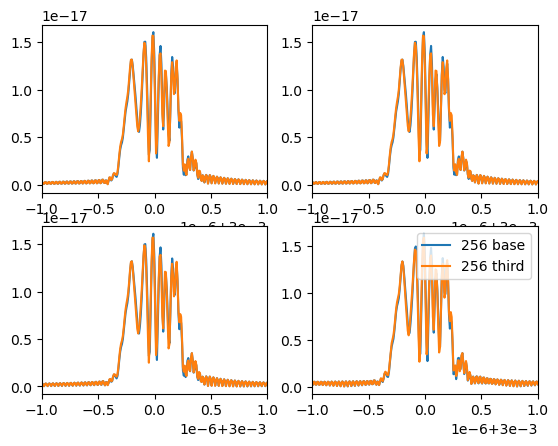

In [48]:
amp = 2e-23  # amplitude
f0 = 3e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
inc = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta_sky = 0.5  # ecliptic latitude
A2 = 400.0  # third body amplitude parameter
varpi = 0.0  # varpi phase parameter
e2 = 0.3  # eccentricity of third body
P2 = 1.2  # period of third body
T2 = 0.5 * P2  # time of periapsis passage of third body


Tobs = 4 * YRSID_SI
df = 1/ Tobs
fig, ax = plt.subplots(2, 2)
ax = ax.ravel()
for i, N in enumerate([256, 1024, 8192, 16384][::-1]):
    gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=N)  # T=Tobs, oversample=4)
    
    ax[i].plot(gb.freqs[0], np.abs(gb.A[0]), label=str(N) + " base")
    gb_third.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, A2, varpi, e2, P2, T2, N=N)  # T=Tobs, oversample=4)
    ax[i].plot(gb_third.freqs[0], np.abs(gb_third.A[0]), label=str(N) + " third")
    ax[i].set_xlim(0.002999, 0.003001)

    base = DataResidualArray([gb.A[0], gb.E[0]], f_arr=gb.freqs[0])
    third = DataResidualArray([gb_third.A[0], gb_third.E[0]], f_arr=gb_third.freqs[0])
    
    overlap = inner_product(base, third, psd="A1TDISens", normalize=True)
    print(overlap, N)
    
    
# gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=256)  # T=Tobs, oversample=4)
ax[-1].legend()
# plt.plot(gb.freqs[0], np.abs(gb.A[0]))


## Task 2: Run an MCMC over 

In [5]:
from eryn.prior import uniform_dist, ProbDistContainer

In [6]:
priors = {"gb": ProbDistContainer({
    0: uniform_dist(1e-23, 1e-21),
    1: uniform_dist(0.003995, 0.004005),
    2: uniform_dist(1e-18, 1e-17),
    3: uniform_dist(0.0, 2 * np.pi),
    4: uniform_dist(0.0, np.pi),  # should be over cosine of inclination, but this is simpler for examples
    5: uniform_dist(0.0, np.pi)
})}
lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])


In [7]:
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray
from lisatools.sensitivity import AE1SensitivityMatrix

In [8]:
N_wave = 256
def like_wrap(x, analysis1, data, fd, Tobs, dt, default_values):
    input_parameters = np.zeros(9)
    input_parameters[np.array([0, 1, 2, 4, 5, 6])] = x
    input_parameters[np.array([7, 8])] = default_values
    # print(input_parameters)
    gb.run_wave(*input_parameters, T=Tobs, dt=dt, N=N_wave)  # T=Tobs, oversample=4)
    
    A = gb.A[0]
    E = gb.E[0]
    # print(A[::100], check[0][::100])
    # print(gb.freqs[0][::100], check_freqs[::100])

    start_ind = int(gb.freqs[0][0] / df)
    template = DataResidualArray(np.array([A, E]), f_arr=gb.freqs[0])
    data_tmp = DataResidualArray(data[:, start_ind:start_ind + N_wave], f_arr=fd[start_ind:start_ind + N_wave])
    sens_mat = AE1SensitivityMatrix(data_tmp.f_arr)
    analysis = AnalysisContainer(data_tmp, sens_mat)
    # fig, ax = data_tmp.loglog()
    # print(data_tmp.shape)
    # plt.show()
    # template.loglog()
    # plt.show()
    ll = analysis.template_likelihood(template)
    return ll

In [9]:
injection_params = np.array([
    amp, 
    f0,
    fdot,
    0.0,
    phi0,
    inc,
    psi,
    lam,
    beta
])
print(injection_params)

Tobs = YRSID_SI
dt = 5.0
N = int(Tobs / dt)
Tobs = N * dt
df = 1 / Tobs
# TODO: fix DataREsidualArray frequency check error here with df=
f_arr = np.arange(0.0, 1/(2 * dt) + df, df)
data_orig = np.asarray(gb.inject_signal(*injection_params, T=Tobs, dt=dt, N=N_wave))
data = DataResidualArray(data_orig.copy(), f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data, sens_mat)
check = data[:][np.where(data[:])].reshape(2, 256)
check_freqs = f_arr[np.where(data[0])]

[ 1.00000000e-22  4.00000000e-03  1.00000000e-17  0.00000000e+00
  2.30000000e+00  6.00420588e-01  2.98032200e+00  4.13000000e+00
 -1.50000000e-01]


/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:84: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:86: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:88: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:93: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/test_lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:95: RuntimeWarning: invalid value encountered in multiply


In [10]:
sampling_injection_params = np.array([
    amp,
    f0,
    fdot,
    phi0,
    inc,
    psi
])
print(f0)
like_wrap(sampling_injection_params, analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values)

0.004


-3.637978807091713e-12

In [11]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State

In [12]:
ndims = {"gb": 6}
nwalkers = 24
ntemps = 10
sampler = EnsembleSampler(
    nwalkers,
    ndims, 
    like_wrap,
    priors,
    branch_names=["gb"],
    args=(analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values),
    tempering_kwargs=dict(ntemps=10),
    nleaves_max={"gb": 1},
)

In [13]:
start_state = State({"gb": priors["gb"].rvs(size=(ntemps, nwalkers, 1))})

In [14]:
nsteps = 2000
sampler.run_mcmc(start_state, nsteps, burn=1000, progress=True)

100%|███████████████████████████████████████| 2000/2000 [12:09<00:00,  2.74it/s]


In [15]:
from chainconsumer import Chain, ChainConsumer
import pandas as pd

In [16]:
cold_chain = sampler.get_chain()["gb"][:, 0, :, 0].reshape(-1, 6)
c = ChainConsumer()

df1 = pd.DataFrame({name: val for name, val in zip(["amp", "f0", "fdot", "phi0", "inc", "psi"], cold_chain.T)}) 
c.add_chain(Chain(samples=df1, name=str(chain_i)))
fig = c.plotter.plot()

NameError: name 'chain_i' is not defined

In [ ]:
sampler.get_log_like()[-1, 0]

## Task 3: RJ with GBs

In [ ]:
def fill_template(template, A, E, freqs, Tobs, dt):
    lowest_start_ind = int(1e10)
    highest_end_ind = -1
    for i in range(A.shape[0]):
        start_ind = gb.start_inds[i]
        end_ind = start_ind + N_wave
        
        assert end_ind - start_ind == gb.freqs.shape[1]
        template[0, start_ind:end_ind] += A[i]
        template[1, start_ind:end_ind] += E[i]

def generate_global_template(template, params_all, Tobs, dt):
    gb.run_wave(*params_all.T, T=Tobs, dt=dt, N=N_wave)  # T=Tobs, oversample=4)
    fill_template(template, gb.A, gb.E, gb.freqs, Tobs, dt)
    
def global_log_likelihood(params_all, analysis, Tobs, dt, default_values):
    input_parameters = np.zeros((params_all.shape[0], 9))
    input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = params_all
    input_parameters[:, np.array([7, 8])] = default_values
    # print(input_parameters)
    
    template = np.zeros_like(analysis.data_res_arr[:])

    generate_global_template(template, input_parameters, Tobs, dt)
    template_in = DataResidualArray(template, f_arr=f_arr)
    ll = analysis.template_likelihood(template_in)
    return ll

In [ ]:
injection_params_all = priors["gb"].rvs(size=5)
input_parameters = np.zeros((injection_params_all.shape[0], 9))
input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = injection_params_all
input_parameters[:, np.array([7, 8])] = default_values
data = np.zeros((2, len(f_arr)), dtype=complex)

generate_global_template(data, input_parameters, Tobs, dt)
inds = np.where(data[0])
plt.loglog(f_arr[inds], np.abs(data[0][inds]))

In [ ]:
data_arr = DataResidualArray(data, f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data_arr, sens_mat)

In [ ]:
global_log_likelihood(injection_params_all[1:], analysis, Tobs, dt, default_values)

In [ ]:
from eryn.moves import GaussianMove

In [ ]:
nleaves_max = {"gb": 10}
nleaves_min = {"gb": 0}
ndims = {"gb": 6}

nwalkers = 14
ntemps = 12

factor = 0.001
cov    = {"gb": np.diag(np.array([1., 1e-9, 1., 1., 1., 1.])) * factor}
moves = GaussianMove(cov)

sampler_rj = EnsembleSampler(
    nwalkers,
    ndims,
    global_log_likelihood,
    priors,
    branch_names=["gb"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    args=(analysis, Tobs, dt, default_values),
    rj_moves=True,
    moves=moves,
    tempering_kwargs=dict(ntemps=ntemps)
)

In [ ]:
start_points = {"gb": priors["gb"].rvs(size=(ntemps, nwalkers, nleaves_max["gb"]))}
inds_tmp = np.zeros((ntemps, nwalkers, nleaves_max["gb"]), dtype=bool)
inds_tmp[:, :, 1] = True

start_state = State(start_points, inds={"gb": inds_tmp})

nsteps = 10
sampler_rj.run_mcmc(start_state, nsteps, progress=True)